In [1]:
import time  # для получения времени решения системы уравнений с разреженной матрицей
import cv2   # для базовых операций с изображениями
import matplotlib.pyplot as plt # отображение результатов решения поставленной задачи
import numpy as np # работа с матрицами и многомерными массивами
# для работы с разреженными матрицами и встроенными функциями решения 
# систем линейных алгебраических уравнений
import scipy.sparse as sp 
from scipy.sparse import spdiags # для задания разреженны матриц леточной структуры
from scipy.sparse.linalg import spsolve # солвер решения системы линейных уравнений
plt.rcParams['figure.figsize'] = [15, 5] # для размера отображения всех изображений

In [2]:
# чтение контейнера (куда будет выполнена вставка шаблона)
img = cv2.imread('Container.jpg')
imgContainer = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgContainerStart = imgContainer.copy()
# чтение шаблока (он будет вставлен в контейнер)
img = cv2.imread('Template.jpg')
imgInsert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
nx, ny, channel = imgInsert.shape
Nx, Ny, Channel = imgContainer.shape
nx -= 2; ny -= 2; N = nx*ny

In [3]:
# Один из главных методов решения задачи вставки шаблона
# метод создания главной матрици в разреженном виде для СЛАУ
def CreateSparseMatrix(nx,ny): 
    Ones = np.ones((N,)) # задаем шаблон коэффициентов из единиц
    data = np.array([Ones, Ones, -4*Ones, Ones, Ones]) # формируем ленты матрицы на основании ф-ра Лапласа
    diags = np.array([-ny, -1, 0, 1, ny]) # фомируем местоположения лент в матрице
    A = spdiags(data, diags, N, N);  A = sp.csr_matrix(A) # сформировали матрицу, сделали доступ к ней
    for i in range(ny,N,ny):  A[i,i-1]=A[i-1,i]=0 # удаляем лтшние коэффициенты в матрице для 2-х лент
    # отображаем разреженную матрицу (точками показывает ненулевые элементи и их расположение)
    plt.subplot(131), plt.spy(A, markersize=0.1), plt.grid(True), plt.title('Full Sparse Matrix')
    # отображаем фрагмент разреженной матрицы (ненулевые элементи и их расположение)
    plt.subplot(132), plt.spy(A[0:2*nx+1, 0:2*ny+1], markersize=0.1), plt.grid(True), plt.title('Fragment of Sparse Matrix')
    # отображаем малый фрагмент разреженной матрицы (ненулевые элементи и их расположение)
    plt.subplot(133), plt.spy(A[0:nx//5, 0:ny//5], markersize=1), plt.grid(True), plt.title('Small Fragment of Sparse Matrix')
    
    return A # возвращаем матрицу для того, чтобы ее использовать при решении СЛАУ

In [4]:
# Вторая основная функция для решения поставленной задачи
def FormRightPart(imgInsert,imgContainer):
    imgInsert = np.double(imgInsert) # переходим к double для обработки попиксельной
    imgContainer = np.double(imgContainer) # переходим к double для обработки попиксельной
    # формируем правую часть уравнения Пуассона на основании оператора Лапласа с 2-х частей
    tmp = imgInsert[:-2,1:-1,:] - 2*imgInsert[1:-1,1:-1,:] + imgInsert[2:,1:-1,:]
    tmp += imgInsert[1:-1,:-2,:] - 2*imgInsert[1:-1,1:-1,:] + imgInsert[1:-1,2:,:]

    # Учет граничных условий (тут подтягиваем значения с рамки в контейнере для вставки изображения)
    tmp[:,0,:] -= imgContainer[1:-1,0,:]    # низ
    tmp[:,-1,:] -= imgContainer[1:-1,-1,:]  # верх
    tmp[0,:,:] -= imgContainer[0,1:-1,:]    # лево
    tmp[-1,:,:] -= imgContainer[-1,1:-1,:]  # право

    return tmp # возвращаем правую часть пока что в матричном виде, а не в векторном

In [5]:
# Третья основная функция решения поставленной задачи
# функция преобразования правой части в векторную (переход от матрицы) и решение СЛАУ
def GetSolution(A,B,nx,ny):
    Sol = np.zeros((nx,ny,channel)) # выделяем память под матрицу решения
    for i in range(channel): # решаем уравнение Пуассона для всех каналов в процессе вставки
        b = np.reshape(B[:,:,i],(N,1)) # взяли канали и преобразовали его в вектор
        start = time.time() # стартовая точка отсчета времени решения СЛАУ
        X = spsolve(A,b) # Решили СЛАУ, используя scipy (элементы линейной алгебры)        
        finish = time.time() # конец по времени для решения СЛАУ
        Sol[:,:,i] = np.reshape(X,(nx,ny)) # вектор-решение обратно преобразовали в матрицу
        print('Channel :',i+1,'; Time for Solving of System:',finish-start) #выводим общую информацию

    Sol[Sol>255] = 255; Sol[Sol<0] = 0 # обрабатываем выход за пределы одного бита для RGB
    Sol = np.uint8(Sol) # преобразование в uint8 для дальнейшего отображения решения в виде изображения
    
    return Sol # возврат восстановленного изображения (все каналы)

In [6]:
# Отображения всех результатов работы алгоритма и входных данных 
def ShowRecuveryResult(ImgInsert, ImgContainer, SolInsert):
    # полный переход к uint8 для отображения нужных картинок
    ImgInsert = np.uint8(ImgInsert) # шаблон для вставки
    ImgContainer = np.uint8(ImgContainer) # пустой контейнер
    SolInsert = np.uint8(SolInsert) # заполненный шаблоном контейнер
    plt.subplot(131), plt.imshow(ImgInsert), plt.title('Image for insert')
    plt.subplot(132), plt.imshow(ImgContainer), plt.title('Empty image container')
    plt.subplot(133), plt.imshow(SolInsert), plt.title('Image container with imege for insert')

Inserting number 1 ...
Channel : 1 ; Time for Solving of System: 1.2299034595489502
Channel : 2 ; Time for Solving of System: 0.9837839603424072
Channel : 3 ; Time for Solving of System: 1.8268673419952393
Inserting number 2 ...
Channel : 1 ; Time for Solving of System: 2.5624096393585205
Channel : 2 ; Time for Solving of System: 4.282561302185059
Channel : 3 ; Time for Solving of System: 3.1440491676330566
Inserting number 3 ...
Channel : 1 ; Time for Solving of System: 4.271349668502808
Channel : 2 ; Time for Solving of System: 2.611379861831665
Channel : 3 ; Time for Solving of System: 2.063720941543579
Inserting number 4 ...
Channel : 1 ; Time for Solving of System: 1.0725898742675781
Channel : 2 ; Time for Solving of System: 1.0554373264312744
Channel : 3 ; Time for Solving of System: 2.3045709133148193
Inserting number 5 ...
Channel : 1 ; Time for Solving of System: 0.8927469253540039
Channel : 2 ; Time for Solving of System: 0.8437213897705078
Channel : 3 ; Time for Solving of S

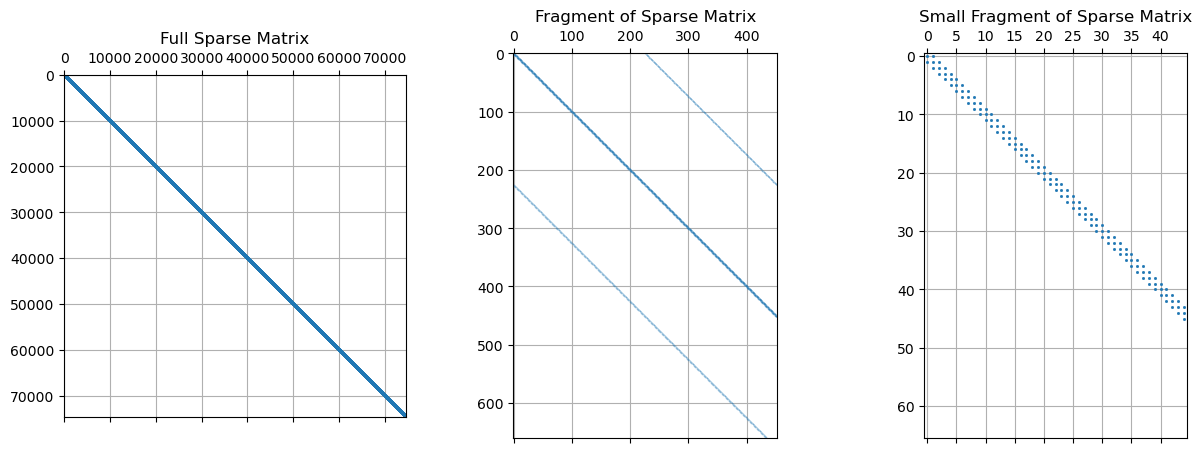

In [7]:
# Создаем позиции для нескольких вставок одного и того же шаблона в разные места в контейнере
dxdy = [] # пока он пуст
for i in range(50):
    for j in range(50):
        s1, s2 = 10 + 2*i*nx, 20 + 2*j*ny # создали левый верхний угол для вствки
        if s1 < Nx-nx-3 and s2 < Ny-ny-3: # если этот угол не выходит за пределы контейнера
            dxdy.append([s1, s2]) # добавляем положение левого верхнего угла

A = CreateSparseMatrix(nx,ny) # вызов метода создания матрицы разреженной СЛАУ

for i in range(len(dxdy)): # проход по всем позициям левого верхнего угла (количпство вствок)
    print('Inserting number',i+1,'...') # вывод информационного сообщения (особий информации не носит)
    # получаем фрагмент, куда будем вставлять наш шаблон
    imgContainerFragment = imgContainer[dxdy[i][0]:dxdy[i][0]+nx+2,dxdy[i][1]:dxdy[i][1]+ny+2,:]    
    # для данного фрагмента формируем матрицу правой части СЛАУ
    b = FormRightPart(imgInsert,imgContainerFragment)
    Sol = GetSolution(A,b,nx,ny) # получаем решения СЛАУ
    # заменяем фрагмент в контейнере новым изображением на основании шаблона вставки
    imgContainer[dxdy[i][0]+1:dxdy[i][0]+nx+1,dxdy[i][1]+1:dxdy[i][1]+ny+1,:] = Sol

True

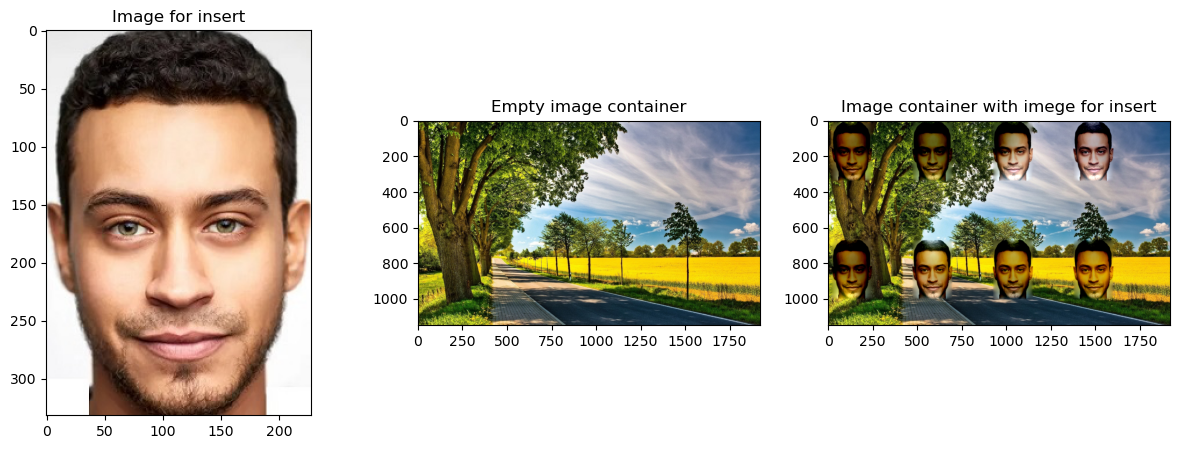

In [8]:
# визуализация результата работы алгортма
ShowRecuveryResult(imgInsert,imgContainerStart, imgContainer)
# запись полученного файла в текущую папку
cv2.imwrite('imgContainer.jpg',cv2.cvtColor(imgContainer, cv2.COLOR_RGB2BGR))

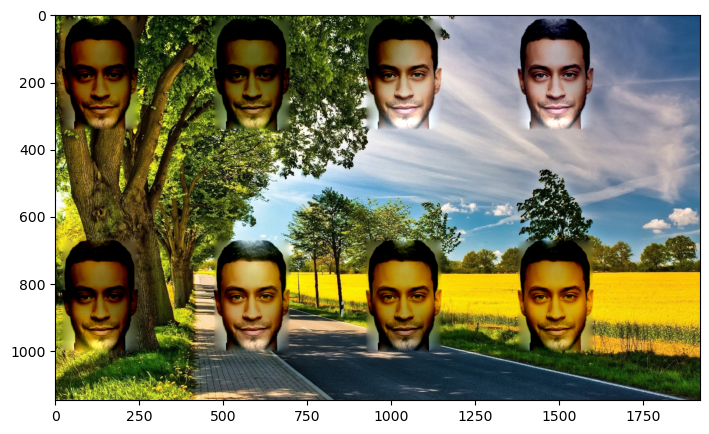

In [9]:
# визуализация полученного результата на весь экран
plt.imshow(imgContainer)